# Index

In [1]:
import copy
import gc
gc.collect()

import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


# the method write myself
from my_toolbox import data_transform as dt
from my_toolbox import data_describe as dd
from my_toolbox import outlier 
from my_toolbox import corr_select as cs
from my_toolbox import missing_value as mv
from my_toolbox import stepwise


Using TensorFlow backend.


In [2]:
path = '../data/'
data_name = ["train", 'test', 'sample_submission']

In [3]:
df_train = pd.read_csv("{}{}.csv".format(path,data_name[0]), encoding='utf8')
print(df_train.shape)

df_test = pd.read_csv("{}{}.csv".format(path,data_name[1]), encoding='utf8')
print(df_test.shape)

df_submission = pd.read_csv("{}{}.csv".format(path,data_name[2]), encoding='utf8')
print(df_submission.shape)

(1460, 81)
(1459, 80)
(1459, 2)


In [4]:
data_describe1 =dd.data_describe(df_train);
data_describe2 = dd.data_describe(df_test);
data_describe1[data_describe1.is_null==True]

,duplicate,is_null,null_number,null_rate(%)
LotFrontage,111,True,259,17.74
Alley,3,True,1369,93.77
MasVnrType,5,True,8,0.55
MasVnrArea,328,True,8,0.55
BsmtQual,5,True,37,2.53
BsmtCond,5,True,37,2.53
BsmtExposure,5,True,38,2.60
BsmtFinType1,7,True,37,2.53
BsmtFinType2,7,True,38,2.60
Electrical,6,True,1,0.07


In [5]:
# define the types of columns

category = ['MSSubClass', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'HouseStyle', 'Condition1', 'Condition2',
            'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 'PavedDrive', 'MoSold', 'SaleCondition',
            'YrSold', 'Electrical', 'MSZoning', 'MasVnrType', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType',
            'GarageType','BldgType']

numeric = ['SalePrice','LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces',
       'GarageCars', 'GarageArea']

category_with_order = ['BsmtCond','LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
                       'ExterQual', 'ExterCond', 'CentralAir', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                       'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
                       'KitchenQual', 'Utilities']

data_type_dict = {'category':category, 'category_with_order':category_with_order}

# set the default type as numeric because df_test doesn't have column 'SalePrice'
default_type = 'numeric'

dd.data_type(data_describe1, default_type, data_type_dict)
dd.data_type(data_describe2, default_type, data_type_dict)

# data_describe1;
# data_describe2;

--- 
# Table: Train
## 1. Category in order
* Normal:   
        LotShape, Utilities, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, CentralAir, HeatingQC, KitchenQual     
* NA is a category:  
        BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageFinish, GarageQual, GarageCond,

In [6]:
# NA is a category; conver null number as 'NA'

tar_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
            'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

dt.NA_as_cat(df_train, tar_list, 'NA')
# ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageCond', 'GarageQual']
df_train[['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageCond', 'GarageQual']].isnull().any()

BsmtQual       False
BsmtCond       False
FireplaceQu    False
GarageCond     False
GarageQual     False
dtype: bool

In [7]:
# transformate order category as number between 0-1

dt.order_cat_to_num(df_train,['ExterQual', 'ExterCond','HeatingQC', 'KitchenQual'],
                    ['Po', 'Fa', 'TA', 'Gd', 'Ex'])
dt.order_cat_to_num(df_train, ['BsmtQual','BsmtCond', 'GarageQual', 'GarageCond', 'FireplaceQu'],
                    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])

dt.order_cat_to_num(df_train, ['BsmtExposure'], ['NA', 'No', 'Mn', 'Av', 'Gd'])

dt.order_cat_to_num(df_train, ['LotShape'], ['IR3', 'IR2', 'IR1', 'Reg'])

dt.order_cat_to_num(df_train, ['Utilities'], ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'])

dt.order_cat_to_num(df_train, ['LandSlope'], ['Sev', 'Mod', 'Gtl'])

dt.order_cat_to_num(df_train, ['OverallQual', 'OverallCond'], [1,2,3,4,5,6,7,8,9,10])

dt.order_cat_to_num(df_train, ['GarageFinish'], ['NA', 'Unf', 'RFn', 'Fin'])

dt.order_cat_to_num(df_train, ['BsmtFinType1','BsmtFinType2'], ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

dt.order_cat_to_num(df_train, ['CentralAir'], ['N', 'Y'])

[back to index](#Index)

## 2. Numeric
* Normal:   
        SalePrice, LotArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal    
* With null number:    
        LotFrontage, MasVnrArea, GarageYrBlt 
* drop the cloumns have too much null numbers:  
        Alley, PoolQC, Fence, MiscFeature'
* year's range is wilde -> take it as numeric
        YearBuilt, YearRemodAdd, GarageYrBlt, 

In [8]:
# if FireplaceQu == np.nan: Fireplaces = 0 
df_train['Fireplaces'] = np.where(df_train['FireplaceQu'] == 0,
                                  0, df_train['Fireplaces'])

In [9]:
# if BsmtHalfBath == np.nan: BsmtHalfBath =0
df_train.fillna({'BsmtHalfBath':0}, inplace=True)

# if BsmtFullBath == np.nan: BsmtFullBath =0
df_train.fillna({'BsmtFullBath':0}, inplace=True)

In [10]:
# if Functional == NULL: Functional = Typ
df_train.fillna({'Functional':'Typ'}, inplace=True)

In [11]:
# have no basement

# if BsmtFinType1 == -1: BsmtFinSF1 = 0  
df_train['BsmtFinSF1'] = np.where(df_train['BsmtFinType1'] == 0,
                                  0, df_train['BsmtFinSF1'])

# if BsmtFinType2 == -1: BsmtFinSF12 = 0  
df_train['BsmtFinSF2'] = np.where(df_train['BsmtFinType2'] == 0,
                                  0, df_train['BsmtFinSF2'])

df_train['TotalBsmtSF'] = np.where(
    (df_train['BsmtFinType2'] == 0)&(df_train['BsmtFinType1'] == 0),
    0, df_train['TotalBsmtSF'])
df_train['BsmtUnfSF'] = np.where(
    (df_train['BsmtFinType2'] == 0)&(df_train['BsmtFinType1'] == 0),
    0, df_train['BsmtUnfSF'])
df_train['BsmtFinSF1'] = np.where(
    (df_train['BsmtFinType2'] == 0)&(df_train['BsmtFinType1'] == 0),
    0, df_train['BsmtFinSF1'])

In [12]:
# drop the cloumns which have too much null numbers
df_train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True, axis=1)
df_train.shape    # check

(1460, 77)

In [13]:
# These columns has many zero. 
# if we just put it in Tukey_test to deal with outlier. it'll cause problems.

print(df_train[['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
 'EnclosedPorch', '3SsnPorch' , 'ScreenPorch', 'PoolArea', 'MiscVal']].head())

   BsmtFinSF2  LowQualFinSF  BsmtHalfBath  KitchenAbvGr  EnclosedPorch  \
0           0             0             0             1              0   
1           0             0             1             1              0   
2           0             0             0             1              0   
3           0             0             0             1            272   
4           0             0             0             1              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  
0          0            0         0        0  
1          0            0         0        0  
2          0            0         0        0  
3          0            0         0        0  
4          0            0         0        0  


In [14]:
# select the quartile beside 0 of each columns, which has too much 0 
q4_tar_list = ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
 'EnclosedPorch', '3SsnPorch' , 'ScreenPorch', 'PoolArea', 'MiscVal']

df_train_outlier_q4 = dd.quartile_level_select(df_train, q4_tar_list, 4,0)
df_train_outlier_q4

[[0, 177.75, 353.0, 551.0, 1474.0],
 [0, 168.25, 377.5, 477.5, 572.0],
 [0, 1.0, 1.0, 1.0, 2.0],
 [0, 1.0, 1.0, 1.0, 3.0],
 [0, 104.25, 144.5, 205.0, 552.0],
 [0, 150.75, 180.0, 239.75, 508.0],
 [0, 143.75, 180.0, 224.0, 480.0],
 [0, 515.5, 555.0, 612.0, 738.0],
 [0, 437.5, 500.0, 887.5, 15500.0]]

In [15]:
# transform data in 0-4 level by persentage  

q4_tar_list = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
               '3SsnPorch' , 'ScreenPorch', 'PoolArea', 'MiscVal']
# q4_tar_list remove 'BsmtHalfBath', 'KitchenAbvGr', because they are already level type

dt.persentage_level_transform (df_train, q4_tar_list, df_train_outlier_q4)    
df_train[q4_tar_list].head(15)   

,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,4,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,4,0,0,4
6,0,0,0,0,0,0,0
7,0,0,4,0,0,0,3
8,0,0,4,0,0,0,0
9,0,0,0,0,0,0,0


In [16]:
# outlier
tar_list=['SalePrice', 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 
          '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
          'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
          'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',  
          'LotFrontage', 'MasVnrArea',
         'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

df_train_tmp = outlier.Tukey_test(df_train, tar_list, k=3)

df_train[list(df_train_tmp.columns)] = df_train_tmp

drop_columns = list(set(tar_list).difference(set(df_train_tmp.columns)))
df_train.drop(drop_columns, inplace=True, axis=1)


# print(df_train[tar_list].shape)
# print(df_train[tar_list].columns)
# print(df_train_tmp.shape)
# print(df_train_tmp.columns)
print(df_train.shape)

# check whether it have string in columns
for col in tar_list:
    count = 0
    for row in range(len(df_train[col])):
        if type(df_train[col][row]) == 'str':
            print(col, row)
            count+=1
    print('"{}" {} numbers:{}'.format(col,'str', count))


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


(1460, 77)
"SalePrice" str numbers:0
"LotArea" str numbers:0
"BsmtFinSF1" str numbers:0
"BsmtUnfSF" str numbers:0
"TotalBsmtSF" str numbers:0
"1stFlrSF" str numbers:0
"2ndFlrSF" str numbers:0
"GrLivArea" str numbers:0
"BsmtFullBath" str numbers:0
"FullBath" str numbers:0
"HalfBath" str numbers:0
"BedroomAbvGr" str numbers:0
"TotRmsAbvGrd" str numbers:0
"Fireplaces" str numbers:0
"GarageCars" str numbers:0
"GarageArea" str numbers:0
"WoodDeckSF" str numbers:0
"OpenPorchSF" str numbers:0
"LotFrontage" str numbers:0
"MasVnrArea" str numbers:0
"YearBuilt" str numbers:0
"YearRemodAdd" str numbers:0
"GarageYrBlt" str numbers:0


In [17]:
# filled missing vales of  'LotFrontage', 'MasVnrArea', 'GarageYrBlt' by KNN 

df_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']] = mv.fill_knn(
    df_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']], 5)

# to check whether it has missing value or not
df_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().any()

C:\Users\Student\Desktop\WorkSpace\House Prices Advanced Regression Techniques\report\my_toolbox\missing_value.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_filled_knn =pd.DataFrame(KNN(k=neighbourhood).fit_transform(df.as_matrix()))


Imputing row 1/1460 with 0 missing, elapsed time: 0.224
Imputing row 101/1460 with 1 missing, elapsed time: 0.224
Imputing row 201/1460 with 0 missing, elapsed time: 0.224
Imputing row 301/1460 with 0 missing, elapsed time: 0.224
Imputing row 401/1460 with 0 missing, elapsed time: 0.224
Imputing row 501/1460 with 0 missing, elapsed time: 0.224
Imputing row 601/1460 with 0 missing, elapsed time: 0.224
Imputing row 701/1460 with 0 missing, elapsed time: 0.224
Imputing row 801/1460 with 0 missing, elapsed time: 0.239
Imputing row 901/1460 with 1 missing, elapsed time: 0.239
Imputing row 1001/1460 with 0 missing, elapsed time: 0.239
Imputing row 1101/1460 with 0 missing, elapsed time: 0.239
Imputing row 1201/1460 with 0 missing, elapsed time: 0.239
Imputing row 1301/1460 with 1 missing, elapsed time: 0.239
Imputing row 1401/1460 with 0 missing, elapsed time: 0.239


LotFrontage    False
MasVnrArea     False
GarageYrBlt    False
dtype: bool

Text(0.5, 1.0, 'Correlation between numeric features')

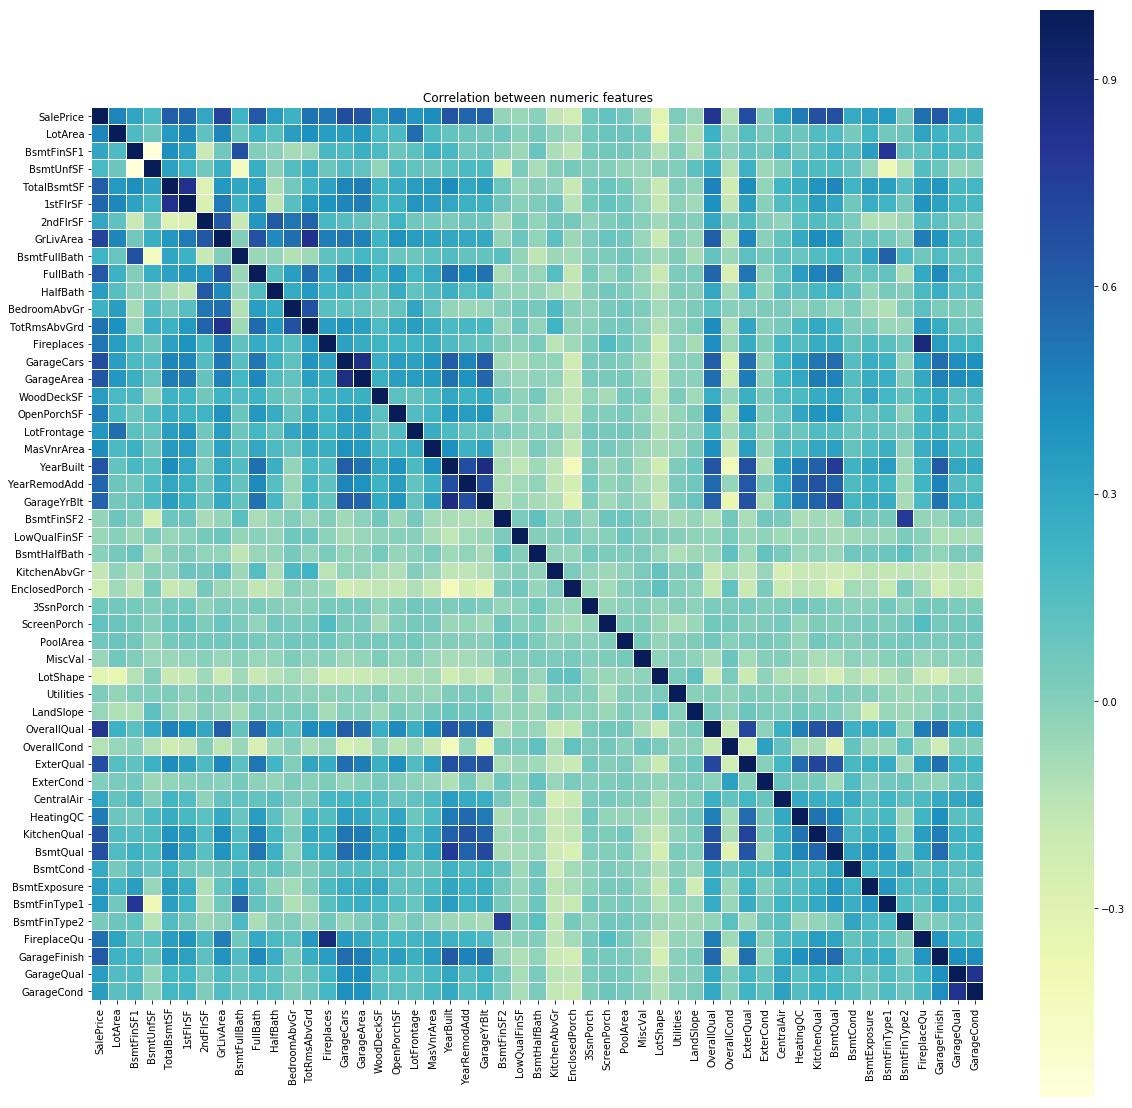

In [18]:
# the columns with many zeros
tar_list.extend(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
 'EnclosedPorch', '3SsnPorch' , 'ScreenPorch', 'PoolArea', 'MiscVal'])
# print(tar_list)

# categories in order
tar_list.extend(['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
                 'ExterQual', 'ExterCond', 'CentralAir', 'HeatingQC', 'KitchenQual',  
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond'])

# correlation table
corr_table = df_train[tar_list].corr(method = 'spearman')
# print(corr_table)

# picture of correlation table
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

g=sns.heatmap(corr_table, vmax=1, linewidths=0.01,
            square=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between numeric features')

In [19]:
# low correlation

drop_list=[]
level = 0.2
for i in tar_list:   # beside row_id and country_code
    if abs(df_train['SalePrice'].corr(df_train[i], method = 'spearman')) < level:
        drop_list.append(i)
print('correlation under %.2f.\n'%level,drop_list)

# corr_select(df_train, 'SalePrice', 'spearman', level)
# multicollinearity_prevent(df_train, 'SalePrice', 'spearman', 0.7)

correlation under 0.20.
 ['BsmtUnfSF', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Utilities', 'LandSlope', 'OverallCond', 'ExterCond', 'BsmtFinType2']


In [20]:
# hight correlation

# Select the columns which has high correlation with SalePrice. 
# Make this columns be square o cubed
square_list=[]
level = 0.6
for i in tar_list:   # beside row_id and country_code
    if abs(df_train['SalePrice'].corr(df_train[i], method = 'spearman')) > level:
        square_list.append(i)
print('correlation heigher than %.2f.\n'%level,square_list)

correlation heigher than 0.60.
 ['SalePrice', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea', 'YearBuilt', 'OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish']


[back to index](#Index)

## 3. Category
* one-hot-encoding(24):  
        MSSubClass, MSZoning, Street, LandContour, LotConfig, Neighborhood, Condition1, Condition2, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, Foundation, Heating, CentralAir(只有2類), PavedDrive, MoSold, SaleType, SaleCondition, YrSold, HouseStyle  
* Has null number(3):    
        MasVnrType, Electrical(FuseA, FuseF, FuseP有序; SBrkr, Mix無序。應拆分), Functional,   
* NA is a category(1): 
        GarageType   

In [21]:
df_train.MSSubClass.apply(str);
df_train.MoSold.apply(str);

In [22]:
#  'GarageType' 76筆空值為一類別
dt.NA_as_cat(df_train, ['GarageType'], fill_with='NA')

### check category features' scatter with SalePrice

In [23]:
# find out the columns with many duplicate categories

# [YearBuilt, YearRemodAdd, GarageYrBlt] -> take them as numeric
data_describe1[(data_describe1['duplicate']>10) & (data_describe1['type']=='category')]

,duplicate,is_null,null_number,null_rate(%),type
MSSubClass,15,False,0,0.00,category
Neighborhood,25,False,0,0.00,category
Exterior1st,15,False,0,0.00,category
Exterior2nd,16,False,0,0.00,category
MoSold,12,False,0,0.00,category


In [24]:
# dt.cat_plot(df_train, 'MasVnrType', 'SalePrice')

# nan is not much fill it with mode
df_train.fillna({'MasVnrType':df_train['MasVnrType'].mode()[0]}, inplace=True)

In [25]:
# most of data gather in SBrkr. Maybe we should drop this column
# dt.cat_plot(df_train, 'Electrical', 'SalePrice')

# nan is not much fill it with mode
df_train.fillna({'Electrical':df_train['Electrical'].mode()[0]}, inplace=True)

In [26]:
# most of data gather in Typ and it's relationship with SalePrice is unclear
# dt.cat_plot(df_train, 'Functional', 'SalePrice')

# we should drop this column
df_train.drop(['Functional'], inplace=True, axis=1)

In [27]:
# most of data gather in Pave  
# dt.cat_plot(df_train, 'Street', 'SalePrice')

# we should drop this column
df_train.drop(['Street'], inplace=True, axis=1)

In [28]:
# scatter is unclear and most of them are gathering in Y
# dt.cat_plot(df_train, 'PavedDrive', 'SalePrice')

# we should drop this column
df_train.drop(['PavedDrive'], inplace=True, axis=1)

In [29]:
# scatter beteen years of saleprice is unclear 
# dt.cat_plot(df_train, 'YrSold', 'SalePrice')

# we should drop this column
df_train.drop(['YrSold'], inplace=True, axis=1)

In [30]:
# scatter beteen years of saleprice is unclear 
# dt.cat_plot(df_train, 'LandContour', 'SalePrice')

# we should drop this column
df_train.drop(['LandContour'], inplace=True, axis=1)

In [31]:
# scatter beteen years of saleprice is unclear 
# dt.cat_plot(df_train, 'LotConfig', 'SalePrice')

# we should drop this column
df_train.drop(['LotConfig'], inplace=True, axis=1)

In [32]:
# scatter beteen years of saleprice is unclear 
# dt.cat_plot(df_train, 'RoofStyle', 'SalePrice')

# we should drop this column
df_train.drop(['RoofStyle'], inplace=True, axis=1)

In [33]:
# check df_train has null number or not
print(df_train.shape)
print(df_train.columns)
df_train.isnull().any().any()

(1460, 70)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'Utilities', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 

False

[back to index](#Index)

## undescide to drop or not 

[back to index](#Index)

In [34]:
# step result

print(df_train.shape, df_train.isnull().any().any())


# one-hot encoding
A = data_describe1[data_describe1['type']=='category'].index
B = df_train.columns

tar_col = set(A).intersection(set(B))

df_train = dt.one_hot_encoding(df_train, tar_col, False)

print(df_train.shape, df_train.isnull().any().any())
print(df_train.columns)

(1460, 70) False
(1460, 221) False
Index(['Id', 'LotFrontage', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       ...
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker'],
      dtype='object', length=221)


---

---
# Table: Test

## 1. Category in order
* Normal:   
       LotShape, Utilities, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, CentralAir, HeatingQC     

* NA is a category:  
        BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageFinish, GarageQual, GarageCond, KitchenQual
          
* has null number:   
        Utilities,

In [35]:
# NA is a category; conver null number as 'NA'

tar_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
            'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

dt.NA_as_cat(df_test, tar_list, 'NA')

In [36]:
#   'Utilities' has only two null numbers, fil it with mode
df_test.fillna({'Utilities':df_test['Utilities'].mode()[0]}, inplace=True)
# print(df_test[df_test['Utilities'].isnull()==True])    # test

In [37]:
# transformate order category as number between 0-1

dt.order_cat_to_num(df_test,['ExterQual', 'ExterCond','HeatingQC', 'KitchenQual'],
                    ['Po', 'Fa', 'TA', 'Gd', 'Ex'])
dt.order_cat_to_num(df_test, ['BsmtQual','BsmtCond', 'GarageQual', 'GarageCond', 'FireplaceQu'],
                    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])

dt.order_cat_to_num(df_test, ['BsmtExposure'], ['NA', 'No', 'Mn', 'Av', 'Gd'])

dt.order_cat_to_num(df_test, ['LotShape'], ['IR3', 'IR2', 'IR1', 'Reg'])

dt.order_cat_to_num(df_test, ['Utilities'], ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'])

dt.order_cat_to_num(df_test, ['LandSlope'], ['Sev', 'Mod', 'Gtl'])

dt.order_cat_to_num(df_test, ['OverallQual', 'OverallCond'], [1,2,3,4,5,6,7,8,9,10])

dt.order_cat_to_num(df_test, ['GarageFinish'], ['NA', 'Unf', 'RFn', 'Fin'])

dt.order_cat_to_num(df_test, ['BsmtFinType1','BsmtFinType2'], ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

dt.order_cat_to_num(df_test, ['CentralAir'], ['N', 'Y'])

## 2. Numeric
* Normal:   
        SalePrice, LotArea, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal    
* has null numbers:    
        LotFrontage, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, Fireplaces, GarageCars, GarageArea
* drop the cloumns have too much null numbers:  
        Alley, PoolQC, Fence, MiscFeature'
* year's range is wilde -> take it as numeric
        YearBuilt, YearRemodAdd, GarageYrBlt, 

In [38]:
# if FireplaceQu == -1: Fireplaces = 0 
df_test['Fireplaces'] = np.where(df_test['FireplaceQu'] == 0,
                                 0, df_test['Fireplaces'])

In [39]:
# if BsmtHalfBath == np.nan: BsmtHalfBath =0
df_test.fillna({'BsmtHalfBath':0}, inplace=True)

# if BsmtFullBath == np.nan: BsmtFullBath =0
df_test.fillna({'BsmtFullBath':0}, inplace=True)

In [40]:
# if BsmtFinType1 == np.nan: BsmtFinSF1 = 0  
df_test['BsmtFinSF1'] = np.where(df_test['BsmtFinType1'] == 0,
                                 0, df_test['BsmtFinSF1'])

# if BsmtFinType2 == np.nan: BsmtFinSF12 = 0  
df_test['BsmtFinSF2'] = np.where(df_test['BsmtFinType2'] == 0, 0, df_test['BsmtFinSF2'])

df_test['TotalBsmtSF'] = np.where(
    (df_test['BsmtFinType2'] == 0)&(df_test['BsmtFinType1'] == 0),
    0, df_test['TotalBsmtSF'])
df_test['BsmtUnfSF'] = np.where(
    (df_test['BsmtFinType2'] == 0)&(df_test['BsmtFinType1'] == 0),
    0, df_test['BsmtUnfSF'])
df_test['BsmtFinSF1'] = np.where(
    (df_test['BsmtFinType2'] == 0)&(df_test['BsmtFinType1'] == 0),
    0, df_test['BsmtFinSF1'])

In [41]:
# if Functional == NULL: Functional = Typ
df_test.fillna({'Functional':'Typ'}, inplace=True)

In [42]:
# drop the cloumns which have too much null numbers
print(df_test.shape)
df_test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True, axis=1)
df_test.shape    # check

(1459, 80)


(1459, 76)

In [43]:
# These columns has many zero. 
# if we just put it in Tukey_test to deal with outlier. it'll cause problems.

print(df_test[['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
 'EnclosedPorch', '3SsnPorch' , 'ScreenPorch', 'PoolArea', 'MiscVal']].head())

   BsmtFinSF2  LowQualFinSF  BsmtHalfBath  KitchenAbvGr  EnclosedPorch  \
0       144.0             0           0.0             1              0   
1         0.0             0           0.0             1              0   
2         0.0             0           0.0             1              0   
3         0.0             0           0.0             1              0   
4         0.0             0           0.0             1              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  
0          0          120         0        0  
1          0            0         0    12500  
2          0            0         0        0  
3          0            0         0        0  
4          0          144         0        0  


In [44]:
# outlier
tar_list=['LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 
          '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
          'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
          'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',  
          'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
         'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

df_test_tmp = outlier.Tukey_test(df_test, tar_list, k=3)

df_test[list(df_test_tmp.columns)] = df_test_tmp

# drop_columns = list(set(tar_list).difference(set(df_test_tmp.columns)))
# df_test.drop(drop_columns, inplace=True, axis=1)


# print(df_test[tar_list].shape)
# print(df_test[tar_list].columns)
# print(df_test_tmp.shape)
# print(df_test_tmp.columns)
print(df_test.shape)

# check whether it have string in columns
for col in tar_list:
    count = 0
    for row in range(len(df_test[col])):
        if type(df_test[col][row]) == 'str':
            print(col, row)
            count+=1
    print('"{}" {} numbers:{}'.format(col,'str', count))

(1459, 76)
"LotArea" str numbers:0
"BsmtFinSF1" str numbers:0


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


"BsmtUnfSF" str numbers:0
"TotalBsmtSF" str numbers:0
"1stFlrSF" str numbers:0
"2ndFlrSF" str numbers:0
"GrLivArea" str numbers:0
"BsmtFullBath" str numbers:0
"FullBath" str numbers:0
"HalfBath" str numbers:0
"BedroomAbvGr" str numbers:0
"TotRmsAbvGrd" str numbers:0
"Fireplaces" str numbers:0
"GarageCars" str numbers:0
"GarageArea" str numbers:0
"WoodDeckSF" str numbers:0
"OpenPorchSF" str numbers:0
"LotFrontage" str numbers:0
"MasVnrArea" str numbers:0
"GarageYrBlt" str numbers:0
"YearBuilt" str numbers:0
"YearRemodAdd" str numbers:0
"GarageYrBlt" str numbers:0


In [45]:
# filled missing vales of  'LotFrontage', 'MasVnrArea', 'GarageYrBlt' by KNN 
null_list = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', 'GarageCars',
            'GarageArea', 'GarageYrBlt']

df_test[null_list] = mv.fill_knn(df_test[null_list], 5)

# to check whether it has missing value or not
df_test[null_list].isnull().any()

C:\Users\Student\Desktop\WorkSpace\House Prices Advanced Regression Techniques\report\my_toolbox\missing_value.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_filled_knn =pd.DataFrame(KNN(k=neighbourhood).fit_transform(df.as_matrix()))


Imputing row 1/1459 with 0 missing, elapsed time: 0.299
Imputing row 101/1459 with 1 missing, elapsed time: 0.299
Imputing row 201/1459 with 0 missing, elapsed time: 0.299
Imputing row 301/1459 with 0 missing, elapsed time: 0.299
Imputing row 401/1459 with 0 missing, elapsed time: 0.299
Imputing row 501/1459 with 0 missing, elapsed time: 0.299
Imputing row 601/1459 with 0 missing, elapsed time: 0.299
Imputing row 701/1459 with 0 missing, elapsed time: 0.299
Imputing row 801/1459 with 0 missing, elapsed time: 0.299
Imputing row 901/1459 with 0 missing, elapsed time: 0.299
Imputing row 1001/1459 with 0 missing, elapsed time: 0.299
Imputing row 1101/1459 with 0 missing, elapsed time: 0.299
Imputing row 1201/1459 with 0 missing, elapsed time: 0.299
Imputing row 1301/1459 with 0 missing, elapsed time: 0.315
Imputing row 1401/1459 with 0 missing, elapsed time: 0.315


LotFrontage     False
MasVnrArea      False
BsmtFinSF1      False
BsmtFinSF2      False
BsmtUnfSF       False
TotalBsmtSF     False
BsmtFullBath    False
BsmtHalfBath    False
Fireplaces      False
GarageCars      False
GarageArea      False
GarageYrBlt     False
dtype: bool

## 3. Category
* one-hot-encoding:  
        MSSubClass,  Street, LandContour, LotConfig, Neighborhood, Condition1, Condition2, RoofStyle, RoofMatl,  Foundation, Heating, CentralAir(只有2類), PavedDrive, MoSold, SaleCondition, YrSold, Electrical(FuseA, FuseF, FuseP有序; SBrkr, Mix無序。應拆分), HouseStyle  
        
* 有空值:    
        MSZoning, MasVnrType, Functional, Exterior1st, Exterior2nd, SaleType  

* NA is a category: 
        GarageType 

In [46]:
df_test.MSSubClass.apply(str);
df_test.MoSold.apply(str);

In [47]:
print(df_test['GarageType'].isnull().sum())
# df_test[df_test['GarageType']==0]

# null means has no Garage
dt.NA_as_cat(df_test, ['GarageType'], fill_with='NA')
print(df_test['GarageType'].isnull().sum())

76
0


In [48]:
# SaleType only has 1 null number, make it be Other
df_test.fillna({'SaleType':'Oth'}, inplace=True)

In [49]:
# MSZoning: 4  → fill with mode
print(df_test.MSZoning.isnull().sum())
df_test.fillna({'MSZoning':df_test['MSZoning'].mode()[0]}, inplace=True)

# MasVnrType: 16  → fill with mode
print(df_test.MasVnrType.isnull().sum())
df_test.fillna({'MasVnrType':df_test['MasVnrType'].mode()[0]}, inplace=True)


# MasVnrArea: 8 → if 'MasVnrType' is 'None', fill it with 0 , else fill it with mode
df_test['MasVnrArea'] = np.where(df_test['MasVnrType'] == 'None', 0, df_test['MasVnrArea'])
print(df_test.MasVnrType.isnull().sum())
df_test.fillna({'MasVnrArea':df_test['MasVnrArea'].mode()[0]}, inplace=True) 

4
16
0


In [50]:
# Functional: 2  
print(df_test.Functional.isnull().sum())
df_test.fillna({'Functional':'Typ'}, inplace=True)

0


In [51]:
# Exterior1st → fill with mode
print(df_test.Exterior1st.isnull().sum())
df_test.fillna({'Exterior1st':df_test['Exterior1st'].mode()[0]}, inplace=True)

# Exterior2nd → fill with mode
print(df_test.Exterior2nd.isnull().sum())
df_test.fillna({'Exterior2nd':df_test['Exterior2nd'].mode()[0]}, inplace=True)

# Utilities → fill with mode
print(df_test.Utilities.isnull().sum())
df_test.fillna({'Utilities':df_test['Utilities'].mode()[0]}, inplace=True)

# KitchenQual → fill with mode
print(df_test.KitchenQual.isnull().sum())
df_test.fillna({'KitchenQual':df_test['KitchenQual'].mode()[0]}, inplace=True)

1
1
0
1


In [52]:
# step result

print(df_test.shape)
print(df_test.columns)
df_test.isnull().any().any()

(1459, 76)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDri

False

In [53]:
# one-hot encoding
A = data_describe2[data_describe2['type']=='category'].index
B = df_test.columns

tar_col = set(A).intersection(set(B))

df_test = dt.one_hot_encoding(df_test, tar_col, False)

print(df_test.shape, df_test.isnull().any().any())
print(df_test.columns)

(1459, 239) False
Index(['Id', 'LotFrontage', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       ...
       'GarageType_NA', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'Heating_GasA', 'Heating_GasW',
       'Heating_Grav', 'Heating_Wall'],
      dtype='object', length=239)


# Transform Data 

## PCA

In [54]:
# multicollinearity

left_col = list(corr_table.index)
multicollinearity_pair = []
level = 0.7


for row in left_col:
    for col in  left_col:
        if row == col: pass
        else: 
            if abs(corr_table[row][col]) > level:
                multicollinearity_pair.append([row, col])

MP = copy.deepcopy(multicollinearity_pair)

for pair_list in MP:
    for item in pair_list:
        if item == 'SalePrice':
            multicollinearity_pair.remove(pair_list)

multicollinearity_pair

[['BsmtFinSF1', 'BsmtFinType1'],
 ['TotalBsmtSF', '1stFlrSF'],
 ['1stFlrSF', 'TotalBsmtSF'],
 ['GrLivArea', 'TotRmsAbvGrd'],
 ['TotRmsAbvGrd', 'GrLivArea'],
 ['Fireplaces', 'FireplaceQu'],
 ['GarageCars', 'GarageArea'],
 ['GarageArea', 'GarageCars'],
 ['YearBuilt', 'GarageYrBlt'],
 ['YearBuilt', 'BsmtQual'],
 ['GarageYrBlt', 'YearBuilt'],
 ['GarageYrBlt', 'BsmtQual'],
 ['BsmtFinSF2', 'BsmtFinType2'],
 ['OverallQual', 'ExterQual'],
 ['ExterQual', 'OverallQual'],
 ['ExterQual', 'KitchenQual'],
 ['KitchenQual', 'ExterQual'],
 ['BsmtQual', 'YearBuilt'],
 ['BsmtQual', 'GarageYrBlt'],
 ['BsmtFinType1', 'BsmtFinSF1'],
 ['BsmtFinType2', 'BsmtFinSF2'],
 ['FireplaceQu', 'Fireplaces'],
 ['GarageQual', 'GarageCond'],
 ['GarageCond', 'GarageQual']]

In [55]:
from sklearn.decomposition import PCA

def pca_reduce_col(df_train, df_test, tar_list, size):
    count=1
    print('df_train size before PCA: ', df_train.shape)
    print('df_test size before PCA: ', df_test.shape)
    
    for tar in tar_list:
        pca = PCA(n_components=size)
        pca = pca.fit(df_train[tar])
        
#         unit_vec = pca.components_
#         print('{} unit components: '.format(tar), unit_vec)

        reduce_data_train = pca.transform(df_train[tar])
        reduce_data_test = pca.transform(df_test[tar])
        
        df_train.drop(columns=tar, inplace=True)
        df_test.drop(columns=tar, inplace=True)
        
        df_train['PCA_{}'.format(count)] = reduce_data_train
        df_test['PCA_{}'.format(count)] = reduce_data_test
        count+=1
        
    print('df_train size after PCA: ', df_train.shape)
    print('df_test size after PCA: ', df_test.shape)
        
        
    
    
pca_list=[['BsmtFinSF1', 'BsmtFinType1'],
          ['BsmtFinSF2', 'BsmtFinType2'],
          ['TotalBsmtSF', '1stFlrSF'],
          ['GrLivArea', 'TotRmsAbvGrd', 'GarageCars'],
          ['Fireplaces', 'FireplaceQu'],
          ['YearBuilt', 'GarageYrBlt', 'BsmtQual'],
          ['OverallQual', 'ExterQual', 'KitchenQual'],
          ['GarageQual', 'GarageCond']]

pca_reduce_col(df_train, df_test, pca_list, size=1)  

# print('df_train size after PCA: ', df_train.shape)
# print('df_test size after PCA: ', df_test.shape)

df_train size before PCA:  (1460, 221)
df_test size before PCA:  (1459, 239)
df_train size after PCA:  (1460, 210)
df_test size after PCA:  (1459, 228)


## Hight Correlation 
Select the columns which has high correlation with SalePrice.   
Make this columns be square or cubed

In [56]:
corr_list = copy.deepcopy(numeric)

# the columns with many zeros
corr_list.extend(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
 'EnclosedPorch', '3SsnPorch' , 'ScreenPorch', 'PoolArea', 'MiscVal'])

# categories in order
corr_list.extend(['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
                 'ExterQual', 'ExterCond', 'CentralAir', 'HeatingQC', 'KitchenQual',  
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond','YearBuilt', 
                 'GarageYrBlt'])
corr_list = list(set(corr_list))
print(len(corr_list))
# PCA
for i in ['BsmtFinSF1', 'BsmtFinType1', 'BsmtFinSF2',
                 'BsmtFinType2', 'TotalBsmtSF', '1stFlrSF',
                 'GrLivArea', 'TotRmsAbvGrd', 'GarageCars',
                 'Fireplaces', 'FireplaceQu', 'YearBuilt', 
                 'GarageYrBlt', 'BsmtQual', 'OverallQual', 
                 'ExterQual', 'KitchenQual', 'GarageQual', 'GarageCond']:
    corr_list.remove(i)

corr_list.extend(['PCA_1', 'PCA_2', 'PCA_3','PCA_4','PCA_5','PCA_6','PCA_7','PCA_8'])
print(len(corr_list))

50
39


# Normalization

In [57]:
df_train[corr_list] = preprocessing.scale(df_train[corr_list])
corr_list_tmp=copy.deepcopy(corr_list)
corr_list_tmp.remove('SalePrice')
df_test[corr_list_tmp] = preprocessing.scale(df_test[corr_list_tmp])
# df_train[corr_list]

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


In [58]:
corr_table = df_train[corr_list].corr(method = 'spearman')

square_list=[]
level = 0.65
for i in corr_list:   # beside row_id and country_code
    if abs(df_train['SalePrice'].corr(df_train[i], method = 'spearman')) > level:
        square_list.append(i)
print('correlation heigher than %.2f.\n'%level,square_list)
print('correlation between PCA_4 and SalePrice:', corr_table['PCA_4']['SalePrice'])
print('correlation between PCA_7 and SalePrice:',corr_table['PCA_7']['SalePrice'])

correlation heigher than 0.65.
 ['SalePrice', 'PCA_4', 'PCA_7']
correlation between PCA_4 and SalePrice: 0.7312740268364021
correlation between PCA_7 and SalePrice: -0.8101101208510761


In [59]:
df_train['PCA_4'] = df_train['PCA_4']**3
df_test['PCA_4'] = df_test['PCA_4']**3

df_train['PCA_7'] = df_train['PCA_7']**3
df_test['PCA_7'] = df_test['PCA_7']**3

## Set same size to csv

In [60]:
train_col = set(df_train.columns)
train_col.remove('SalePrice')

test_col = set(df_test.columns)

res = list(train_col.intersection(test_col))

print('train length',len(train_col), df_train.isnull().any().any())
print('test length',len(test_col), df_test.isnull().any().any())
print('result length',len(res))

train length 209 False
test length 228 False
result length 195


In [61]:
df_test_res = df_test[res]
res.append('SalePrice')
df_train_res = df_train[res]

print(df_train_res.shape, df_train_res.isnull().any().any())
print(df_test_res.shape, df_test_res.isnull().any().any())

(1460, 196) False
(1459, 195) False


In [62]:
# df_train_res.isnull().any().sum()
df_train_res.T[df_train_res.isnull().any()==True].index
# df_train_res.isnull()

Index([], dtype='object')

In [63]:
df_train_res.to_csv('../data/df_train.csv', encoding='utf8', index=False)
df_test_res.to_csv('../data/df_test.csv', encoding='utf8', index=False)